# Exploring precision and recall

**Goal:** to understand precision-recall in the context of classifiers.

In this notebook, we do the following:
 * Train a logistic regression model on Amazon Reviews data
 * Explore various evaluation metrics: 
     * Accuracy, 
     * Confusion Matrix,
     * Precision, and
     * Recall.
 * Explore how metrics can be combined to produce a measure of Cost of an error
 * Explore P&R curves.

In [1]:
import turicreate
import numpy as np

# Part 1. Prepare the Data

In [2]:
products = turicreate.SFrame('../data/amazon_baby.sframe/')

## Extracting `word_count` and sentiments (target column)

We do some feature engineering for this notebooks purposes.

1. Remove punctuation of review text.
2. Remove reviews with "neutral" sentiment (rating = 3).
3. Set reviews with rating >= 4 to be "positive" and those with rating<=2 to be "negative"

In [5]:
import string


def remove_punctuation(text):
    """
    Receives a text as string, uses the string module to remove all punctuation and returns the modified text
    """
    translator = text.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    return text

In [6]:
# Remove punctuation.
review_clean = products['review'].apply(remove_punctuation)

# Count words using turicreate's text analytics
products['word_count'] = turicreate.text_analytics.count_words(review_clean)

# Drop neutral sentiment reviews
products = products[products['rating'] != 3]

# Positive sentiment to +1 and negative sentiment to -1
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [7]:
# Take a quick peek at the dataset
products

name,review,rating,word_count,sentiment
Planetwise Wipe Pouch,it came early and was notdisappointed. i love ...,5.0,"{'recommend': 1.0,'disappointed': 1.0, ...",1
Annas Dream Full Quiltwith 2 Shams ...,Very soft and comfortableand warmer than it ...,5.0,"{'quilt': 1.0, 'this':1.0, 'for': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,This is a product wellworth the purchase. I ...,5.0,"{'tool': 1.0, 'clever':1.0, 'binky': 2.0, ...",1
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,"{'rock': 1.0,'headachesthanks': 1.0, ...",1
Stop Pacifier Suckingwithout tears with ...,"When the Binky Fairy cameto our house, we didn't ...",5.0,"{'thumb': 1.0, 'or': 1.0,'break': 1.0, 'trying': ...",1
A Tale of Baby's Dayswith Peter Rabbit ...,"Lovely book, it's boundtightly so you may no ...",4.0,"{'2995': 1.0, 'for': 1.0,'barnes': 1.0, 'at': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",Perfect for new parents.We were able to keep ...,5.0,"{'right': 1.0, 'because':1.0, 'questions': 1.0, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",A friend of mine pinnedthis product on Pinte ...,5.0,"{'like': 1.0, 'and': 1.0,'changes': 1.0, 'the': ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",This has been an easy wayfor my nanny to record ...,4.0,"{'in': 1.0, 'pages': 1.0,'out': 1.0, 'run': 1.0, ...",1
"Baby Tracker&reg; - DailyChildcare Journal, ...",I love this journal andour nanny uses it ...,4.0,"{'tracker': 1.0, 'now':1.0, 'postits': 1.0, ...",1


## Train-Test split

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [8]:
train_data, test_data = products.random_split(.8, seed=1)

# Part 2. Train a Logistic Regression classifier

We will now train a logistic regression classifier with `sentiment` as the target and `word_count` as the features. 
We use `validation_set=None`.

In [9]:
model = turicreate.logistic_classifier.create(train_data, target='sentiment',
                                              features=['word_count'],
                                              validation_set=None)

Logistic regression:

--------------------------------------------------------

Number of examples          : 133416

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 121712

Number of coefficients      : 121713

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 4        | 0.250000  | 1.537114     | 0.840754          |

| 1         | 9        | 3.250000  | 2.235581     | 0.941514          |

| 2         | 11       | 2.778177  | 2.560743     | 0.942638          |

| 3         | 12       | 2.778177  | 2.782492     | 0.967822          |

| 4         | 13       | 2.778177  | 3.021620     | 0.976495          |

| 5         | 14       | 2.778177  | 3.243955     | 0.976495          |

+-----------+----------+-----------+--------------+-------------------+

# Part 3. Model Evaluation


## Accuracy

Classification Accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

To obtain the accuracy of a trained models with Turi Create, we simply pass the option `metric='accuracy'` to the `evaluate` function. 

In [11]:
# Compute accuracy of our model on Test Data

evaluation = model.evaluate(test_data, metric='accuracy')
accuracy = evaluation['accuracy']

print("Test Accuracy: %s" % accuracy)

Test Accuracy: 0.9221862251019919


#### Baseline: Majority class prediction

The majority classifier model predicts the majority class for all data points. 

We can use the **Majority Class classifier** as a baseline model as point of comparison with a more sophisticated classifier. 

Typically, a good model should beat the majority class classifier.

In [12]:
# The majority class in this dataset is positive reviews i.e. (sentiment=+1))

baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): %s" % baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


**Quiz Question:** Using accuracy as the evaluation metric, was our **logistic regression model** better than the baseline (majority class classifier)?
`A = yes`

## Confusion Matrix

Accuracy alone does not tell the whole story, especially when datasets are very imbalanced. 
For a fuller picture, we turn to the **Confusion Matrix**. 
In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (+1)        |         (-1)         |
+-------+-----+----------------------+----------------------+
| True  |(+1) | # of true positives  | # of false negatives |
| label +-----+----------------------+----------------------+
|       |(-1) | # of false positives | # of true negatives  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [14]:
evaluation = model.evaluate(test_data, metric='confusion_matrix')
confusion_matrix = evaluation['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
1,-1,896
-1,-1,3543
-1,1,1698
1,1,27199


**Quiz Question**: How many predicted values in the **test set** are **false positives**?

`A = 1698`

#### Cost of mistakes


Imagine that you're a manufacturer that sells a baby product on Amazon. You want to monitor your product's reviews in order to respond to complaints.  
Even a few negative reviews may generate a lot of bad publicity about the product, so **you don't want to miss any reviews with negative sentiments** --- meaning you prefer the overhead of false alarms of negative reviews instead of missing negative reviews entirely. 

In other words, **false positives cost more than false negatives** in this specific scenario.

Suppose the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.

**Quiz Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?
`A  = 100*FP + 1*FN = $ 170,696`

In [15]:
100*1698 + 896

170696

## Precision: fraction of correct positive predictions

In real situations we may not always have the exact dollar amounts of cost.
Sometimes we may simply prefer to have the percentage of false positives to be less than, say, 3.5% of total positive predictions (a 96.5% **precision**). 

**Precision** metric is defined as :

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

In [16]:
# First let's compute the precision of the logistic regression classifier on the test_data

precision = model.evaluate(test_data, metric='precision')['precision']
print("Precision on test data: %s" % precision)

Precision on test data: 0.941239575042392


**Quiz Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)
`A = 0.06`

**Quiz Question:** If we wanted to reduce this fraction of false positives to be below 3.5%, we would (select one):

- Discard a sufficient number of positive predictions
- Discard a sufficient number of negative predictins
- Increase threshold for predicting the positive class ($y_{hat} = +1$) `CORRECT`
- Decrease threshold for predicting the positive class ($y_{hat} = +1$)



## Recall: fraction of correctly predicted positive observations

A complementary metric of Precision (not complementary in the strict mathematical sense) is **recall**, which measures the ratio between the number of true positives and that of (factually) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

In [18]:
# Compute the recall on the **test_data**.

evaluation = model.evaluate(test_data, metric='recall')
recall = evaluation['recall']
print("Recall on test data: %s" % recall)

Recall on test data: 0.9681082043068162


**Quiz Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier? 
`A = 0.97`

**Quiz Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?
`A = 1.0, because we do not miss out on any positive observations of the dataset`

# Part 4. Exploring the Precision-Recall tradeoff

We first examine what happens when we use a different threshold value for making class predictions.  
We then explore a range of threshold values and plot the associated precision-recall curve.  


## Effect of threshold (confidence level)

When False Positives are more costly we may want to be more restrictive about making positive predictions. 

Instead of thresholding class probabilities at exactly 0.5, we can choose a higher threshold (confidence level) for predicting +1. 

In [25]:
import numpy as np

def apply_threshold(probabilities, threshold):
    """
    Params:
        * `probabilities` (an SArray of probability values)
        * `threshold` (a float between 0 and 1).
    Returns:
        * an SArray where each element is set to +1 or -1 according to the treshold
    """
    results = probabilities.apply(lambda x: +1 if x > threshold else -1)
    return results

In [26]:
# Compute class probabilities with our model
probabilities = model.predict(test_data, output_type='probability')

# Predict using t=0.5
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)

# Predict using t=0.9
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [27]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 28897


In [28]:
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 25031


**Quiz Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9? `The number of positive predictions decreases as the threshold increases`

## Exploring Precision-Recall as the threshold varies

In [29]:
# Use turicreate.evaluation module to compute Precision and Recall individually

# Threshold = 0.5
precision_default_t = turicreate.evaluation.precision(test_data['sentiment'],
                                        predictions_with_default_threshold)

recall_default_t = turicreate.evaluation.recall(test_data['sentiment'],
                                        predictions_with_default_threshold)

# Threshold = 0.9
precision_high_t = turicreate.evaluation.precision(test_data['sentiment'],
                                        predictions_with_high_threshold)
recall_high_t = turicreate.evaluation.recall(test_data['sentiment'],
                                        predictions_with_high_threshold)

In [30]:
print("Precision (threshold = 0.5): %s" % precision_default_t)
print("Recall (threshold = 0.5)   : %s" % recall_default_t)

Precision (threshold = 0.5): 0.941239575042392
Recall (threshold = 0.5)   : 0.9681082043068162


In [32]:
print("Precision (threshold = 0.9): %s" % precision_high_t)
print("Recall (threshold = 0.9)   : %s" % recall_high_t)

Precision (threshold = 0.9): 0.9728736366905038
Recall (threshold = 0.9)   : 0.8667734472326036


**Quiz Question (variant 1)**: Does the **precision** increase with a higher threshold? `A = yes`

**Quiz Question (variant 2)**: Does the **recall** increase with a higher threshold? `A = No, recall decreases`

## Precision-recall curve

Next we explore various different values of tresholds, we compute the precision and recall scores, and then we plot the corresponding precision-recall curve.

In [33]:
# Generate a set of different values for parameter t
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [34]:
# For each of the values of threshold, we compute the precision and recall scores.

precision_all = []
recall_all = []

# Compute class probabilities of test data
probabilities = model.predict(test_data, output_type='probability')

for t in threshold_values:
    # Compute predictions according to current threshold
    predictions = apply_threshold(probabilities, t)
    
    # Compute P&R according to resulting predictions
    precision = turicreate.evaluation.precision(test_data['sentiment'], predictions)
    recall = turicreate.evaluation.recall(test_data['sentiment'], predictions)
    
    # Store the metrics
    precision_all.append(precision)
    recall_all.append(recall)

We now plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

<ipython-input-35-f986352cf0b3>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')


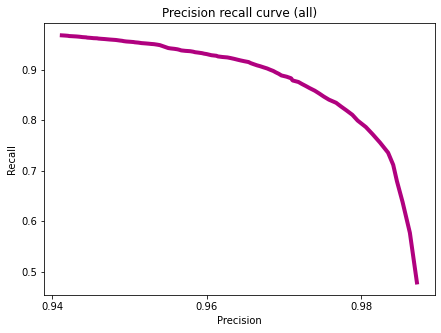

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.
`À = 0.813`

In [36]:
for i in range(len(threshold_values)):
    if precision_all[i] >= 0.965:
        print(threshold_values[i])
        break
    

0.8131313131313131


**Quiz Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? 

`A = 9056`
_Note: This is the number of false negatives (i.e the number of false alarm negative reviews) that we have to deal with using this classifier._

In [38]:
# We use the built-in `turicreate.evaluation.confusion_matrix` function 

predictions = apply_threshold(probabilities, 0.98)

turicreate.evaluation.confusion_matrix(test_data['sentiment'], predictions)

target_label,predicted_label,count
1,-1,9056
1,1,19039
-1,-1,4943
-1,1,298


# Part 5. Evaluating for specific search terms in reviews

Let's select reviews using a specific search term and optimize the precision on these reviews only. (A manufacturer would be interested in tuning the false positive rate just for their products rather than the entire set of products on Amazon)

## Precision-Recall on baby related items

We select from the **test set** all reviews for all products with the word _'baby'_ in them.

In [55]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

Predict the class probability (+1) of these reviews

In [56]:
probabilities = model.predict(baby_reviews, output_type='probability')

Plot the precision-recall curve for the **baby_reviews** dataset.

**First**, consider the following `threshold_values` ranging from 0.5 to 1:

In [57]:
threshold_values = np.linspace(0.5, 1, num=100)

**Second**, compute precision and recall for each value in `threshold_values` on the `baby_reviews` dataset.

In [58]:
babies_precision_all = []
babies_recall_all = []

for t in threshold_values:
    
    predictions = apply_threshold(probabilities, t)

    precision = turicreate.evaluation.precision(baby_reviews['sentiment'], predictions)
    
    recall = turicreate.evaluation.recall(baby_reviews['sentiment'], predictions)
    
    # Append the precision and recall scores.
    babies_precision_all.append(precision)
    babies_recall_all.append(recall)

**Quiz Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **baby_reviews**? Round your answer to 3 decimal places.

In [60]:
for i in range(len(threshold_values)):
    if babies_precision_all[i] >= 0.965:
        print(threshold_values[i])
        break

0.8484848484848485


**Quiz Question:** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?
`A = it's the same!`

**Finally**, let's plot the precision recall curve.

<ipython-input-35-f986352cf0b3>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')


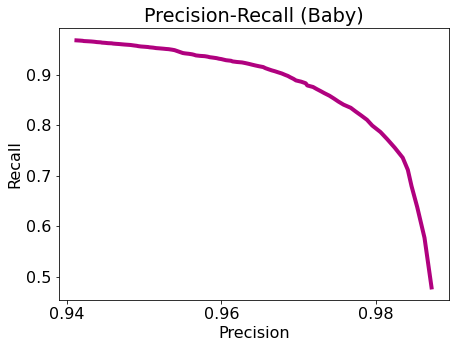

In [54]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (Baby)")